# Librraies

In [71]:
# Import necessary modules from TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, Conv2D, DepthwiseConv2D, 
    GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D, Flatten, Add, Activation, concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Import additional libraries for data processing and evaluation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# Base  Vgg16 Model

In [72]:
def depthwise_separable_conv_block(x, filters, kernel_size=(3, 3), strides=(1, 1)):
    x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = Conv2D(filters, kernel_size=(1, 1), padding='same')(x)
    return x

# Inception module
def inception_module(x, filters):
    f1, f3_r, f3, f5_r, f5, f_pool = filters
    branch1x1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)
    branch3x3 = Conv2D(f3_r, (1, 1), padding='same', activation='relu')(x)
    branch3x3 = Conv2D(f3, (3, 3), padding='same', activation='relu')(branch3x3)
    branch5x5 = Conv2D(f5_r, (1, 1), padding='same', activation='relu')(x)
    branch5x5 = Conv2D(f5, (5, 5), padding='same', activation='relu')(branch5x5)
    branch_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(f_pool, (1, 1), padding='same', activation='relu')(branch_pool)
    outputs = concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=-1)
    return outputs

# Residual block similar to ResNet
def residual_block(x, filters, kernel_size=(3, 3), stride=(1, 1)):
    shortcut = x 
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x
def build_vgg16_modified(input_shape=(32, 32, 3), num_classes=10, 
                         block_type='simple', include_global_avg_pooling=True):
    inputs = Input(shape=input_shape)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model(inputs)
    
    if block_type == 'depthwise':
        x = depthwise_separable_conv_block(x, filters=64)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
    elif block_type == 'inception':
        x = inception_module(x, filters=[64, 128, 128, 32, 32, 32])
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # Added padding='same'
    elif block_type == 'residual':
        x = residual_block(x, filters=64)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # Added padding='same'
    else:
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)  # Added padding='same'

    if include_global_avg_pooling:
        x = GlobalAveragePooling2D()(x)
    else:
        x = Flatten()(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# fine tune the model

In [73]:
def train_model(model, train_dataset, val_dataset=None, epochs=10, batch_size=32):
    history = model.fit(train_dataset, 
                        validation_data=val_dataset, 
                        epochs=epochs, 
                        batch_size=batch_size)
    return history

def fine_tune_model(model, train_dataset, val_dataset=None, layers_to_unfreeze=None, learning_rate=1e-5, epochs=5):
    if layers_to_unfreeze is None:
        for layer in model.layers:
            layer.trainable = True
    else:
        for layer in layers_to_unfreeze:
            layer.trainable = True
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(train_dataset, 
                        validation_data=val_dataset, 
                        epochs=epochs)
    return history


# Model Evaluation

In [74]:
def evaluate_model(model, test_dataset):
    loss, accuracy = model.evaluate(test_dataset)
    print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.concatenate([y for _, y in test_dataset], axis=0)
    y_true = np.argmax(y_true, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)]))
    return loss, accuracy

# Load Data set

In [75]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocessing

In [76]:
x_train_half = x_train[:1000]
y_train_half = y_train[:1000].flatten() 
x_train_half = x_train_half.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train_half = to_categorical(y_train_half, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
print("Number of training images (half):", len(x_train_half))
print("Number of training labels (half):", len(y_train_half))
print("Number of test images:", len(x_test))
print("Number of test labels:", len(y_test))
def create_dataset(images, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.batch(batch_size)
    return dataset
train_dataset = create_dataset(x_train_half, y_train_half, batch_size=32)
test_dataset = create_dataset(x_test, y_test, batch_size=32)

Number of training images (half): 1000
Number of training labels (half): 1000
Number of test images: 10000
Number of test labels: 10000


# Train the basic vgg16 model

In [77]:
model = build_vgg16_modified(input_shape=(32, 32, 3), num_classes=10,block_type='simple', include_global_avg_pooling=False)
train_model(model, train_dataset, epochs=10, batch_size=32)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.1446 - loss: 3.2841
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.2657 - loss: 2.4108
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.2824 - loss: 2.2912
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.3474 - loss: 2.1224
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.3812 - loss: 1.9430
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.4031 - loss: 1.7596
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.4374 - loss: 1.6899
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.4612 - loss: 1.5838
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.5215 - loss: 1.4888
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.5344 - loss: 1.3463


# Evaluate basic vgg16 model

Evaluation of the Normal Model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 154ms/step - accuracy: 0.3402 - loss: 1.8450
Loss: 1.8498, Accuracy: 0.3372
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 160ms/step


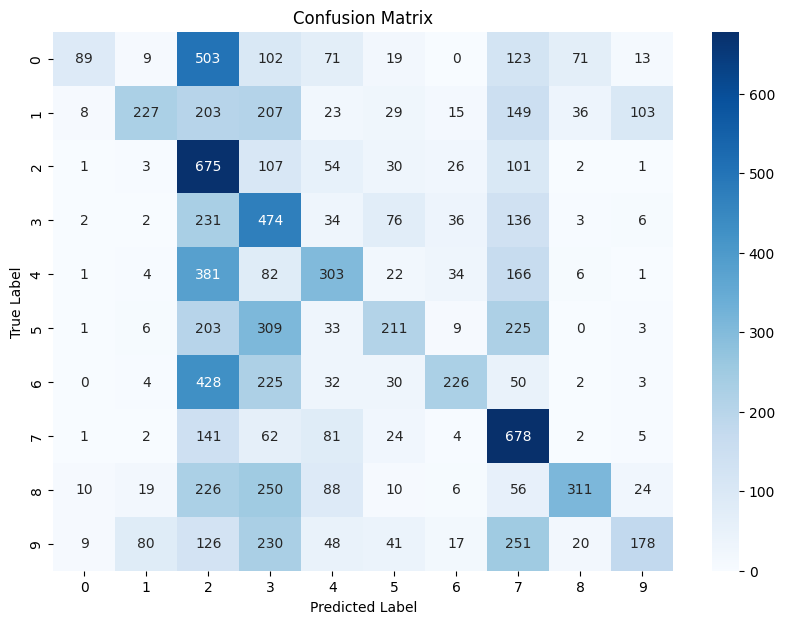


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.09      0.16      1000
           1       0.64      0.23      0.33      1000
           2       0.22      0.68      0.33      1000
           3       0.23      0.47      0.31      1000
           4       0.40      0.30      0.34      1000
           5       0.43      0.21      0.28      1000
           6       0.61      0.23      0.33      1000
           7       0.35      0.68      0.46      1000
           8       0.69      0.31      0.43      1000
           9       0.53      0.18      0.27      1000

    accuracy                           0.34     10000
   macro avg       0.48      0.34      0.32     10000
weighted avg       0.48      0.34      0.32     10000



(1.84976327419281, 0.33719998598098755)

In [78]:
print("Evaluation of the Normal Model:")
evaluate_model(model, test_dataset)

# Fine tune the data 

Epoch 1/5


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.5749 - loss: 1.2498
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.5833 - loss: 1.2557
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.5540 - loss: 1.2609
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.5712 - loss: 1.2465
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.5677 - loss: 1.2391
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.5823 - loss: 1.2442
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.5677 - loss: 1.2726
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.5482 - loss: 1.3177
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.5567 - loss: 1.2704
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step - accuracy: 0.5980 - loss: 1.2328
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step - accuracy: 0.5988 - loss: 1.2401
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - accuracy: 0.57

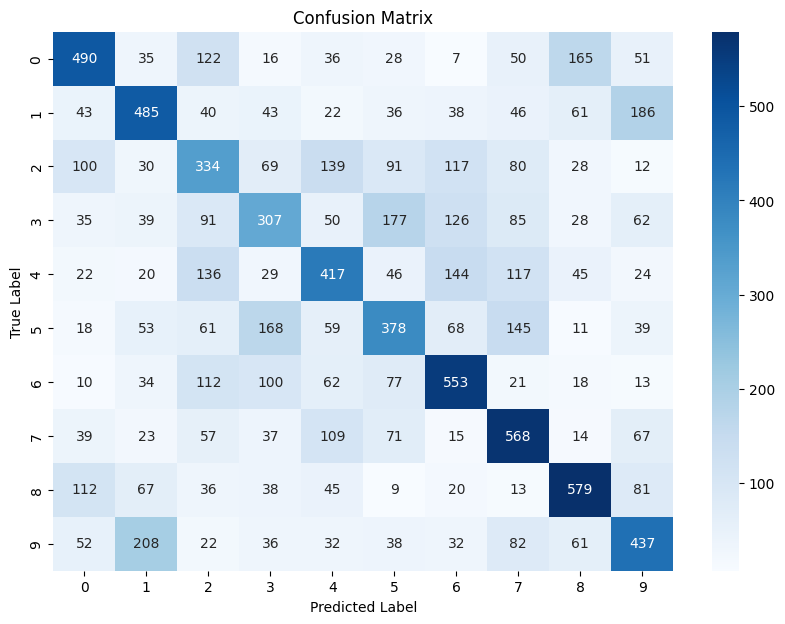


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.49      0.51      1000
           1       0.49      0.48      0.49      1000
           2       0.33      0.33      0.33      1000
           3       0.36      0.31      0.33      1000
           4       0.43      0.42      0.42      1000
           5       0.40      0.38      0.39      1000
           6       0.49      0.55      0.52      1000
           7       0.47      0.57      0.51      1000
           8       0.57      0.58      0.58      1000
           9       0.45      0.44      0.44      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000
weighted avg       0.45      0.45      0.45     10000



(1.597898244857788, 0.454800009727478)

In [80]:
fine_tune_model(model,train_dataset, layers_to_unfreeze=None, learning_rate=1e-5)  # Fine-tune all layers
train_model(model, train_dataset, epochs=10)
print("Evaluation of the Fine-Tuned Model:")
evaluate_model(model, test_dataset)

# use depth wise to convert VGG16 into  MobileNet

In [82]:
model = build_vgg16_modified(input_shape=(32, 32, 3), num_classes=10,block_type = 'depthwise', include_global_avg_pooling=False)
fine_tune_model(model,train_dataset, layers_to_unfreeze=None, learning_rate=1e-5)
train_model(model, train_dataset, epochs=10)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.0994 - loss: 3.7345
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.1129 - loss: 3.6980
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.1103 - loss: 3.7842
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.0807 - loss: 3.8655
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.0980 - loss: 3.6980
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.1036 - loss: 3.6577
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.1055 - loss: 3.6173
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.0990 - loss: 3.6709
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.1028 - loss: 3.7038
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.1263 - loss: 3.6071
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.0944 - loss: 3.6623
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accur

Evaluation of the Fine-Tuned Model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 180ms/step - accuracy: 0.1250 - loss: 2.4689
Loss: 2.4757, Accuracy: 0.1252
313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 161ms/step


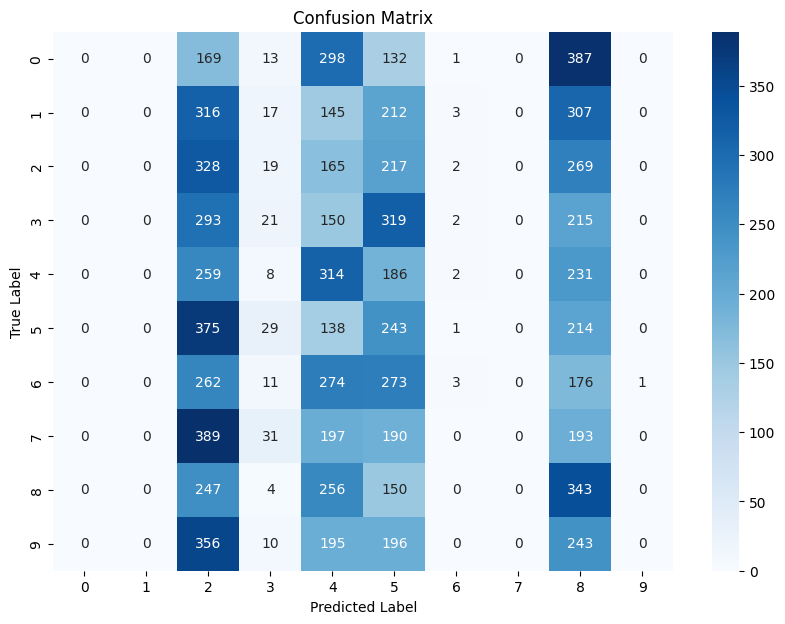


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.11      0.33      0.16      1000
           3       0.13      0.02      0.04      1000
           4       0.15      0.31      0.20      1000
           5       0.11      0.24      0.16      1000
           6       0.21      0.00      0.01      1000
           7       0.00      0.00      0.00      1000
           8       0.13      0.34      0.19      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.13     10000
   macro avg       0.08      0.13      0.08     10000
weighted avg       0.08      0.13      0.08     10000



c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

(2.475705862045288, 0.12520000338554382)

In [83]:

print("Evaluation of the Fine-Tuned Model:")
evaluate_model(model, test_dataset)

#  introduce Inception module  to conver vgg16 into GoogleNet,

In [84]:
model = build_vgg16_modified(input_shape=(32, 32, 3), num_classes=10,block_type = 'inception')
fine_tune_model(model,train_dataset, layers_to_unfreeze=None, learning_rate=1e-5)
train_model(model, train_dataset, epochs=10)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.0887 - loss: 3.7438
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step - accuracy: 0.1032 - loss: 3.5577
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 270ms/step - accuracy: 0.1016 - loss: 3.6547
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.1160 - loss: 3.5176
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.1144 - loss: 3.5381
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.1126 - loss: 3.3926
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.1154 - loss: 3.5272
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.1046 - loss: 3.5525
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.1302 - loss: 3.4332
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.1080 - loss: 3.3694
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.0955 - loss: 3.4532
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accu

Evaluation of the Fine-Tuned Model:


313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 144ms/step - accuracy: 0.1147 - loss: 2.5314
Loss: 2.5335, Accuracy: 0.1155
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 157ms/step


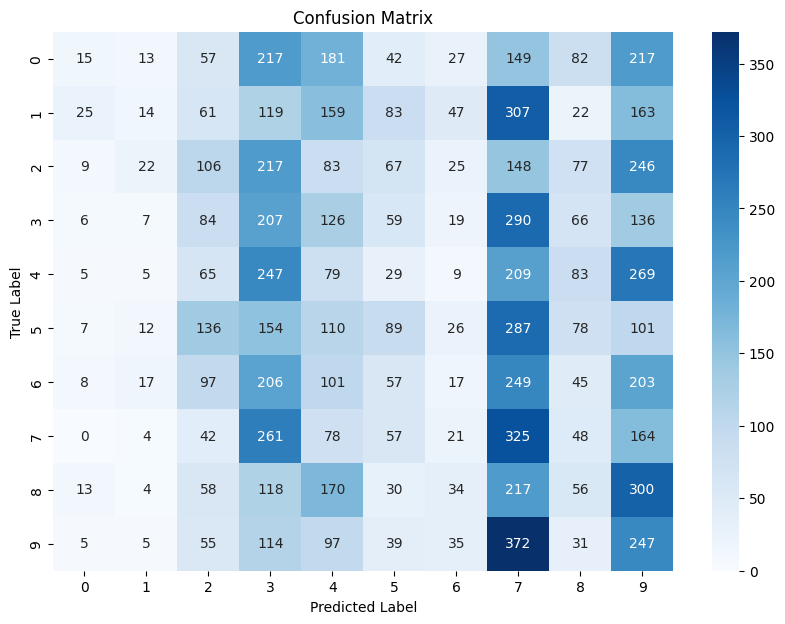


Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.01      0.03      1000
           1       0.14      0.01      0.03      1000
           2       0.14      0.11      0.12      1000
           3       0.11      0.21      0.14      1000
           4       0.07      0.08      0.07      1000
           5       0.16      0.09      0.11      1000
           6       0.07      0.02      0.03      1000
           7       0.13      0.33      0.18      1000
           8       0.10      0.06      0.07      1000
           9       0.12      0.25      0.16      1000

    accuracy                           0.12     10000
   macro avg       0.12      0.12      0.09     10000
weighted avg       0.12      0.12      0.09     10000



(2.533548593521118, 0.11550000309944153)

In [85]:
print("Evaluation of the Fine-Tuned Model:")
evaluate_model(model, test_dataset)

# include  residual block     in Vgg16 to convert it into ResNet50

In [87]:
model = build_vgg16_modified(input_shape=(32, 32, 3), num_classes=10,block_type = 'residual')
fine_tune_model(model,train_dataset, layers_to_unfreeze=None, learning_rate=1e-5) 
train_model(model, train_dataset, epochs=10)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.1160 - loss: 3.5813
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.1050 - loss: 3.5763
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.1060 - loss: 3.6008
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.1089 - loss: 3.5091
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.1113 - loss: 3.4463
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.1318 - loss: 3.2999
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.1014 - loss: 3.4864
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.1157 - loss: 3.5422
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.1147 - loss: 3.4678
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.1097 - loss: 3.4953
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.1038 - loss: 3.5025
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accu

Evaluation of the Fine-Tuned Model:
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 165ms/step - accuracy: 0.1236 - loss: 2.3895
Loss: 2.3853, Accuracy: 0.1293
313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 180ms/step


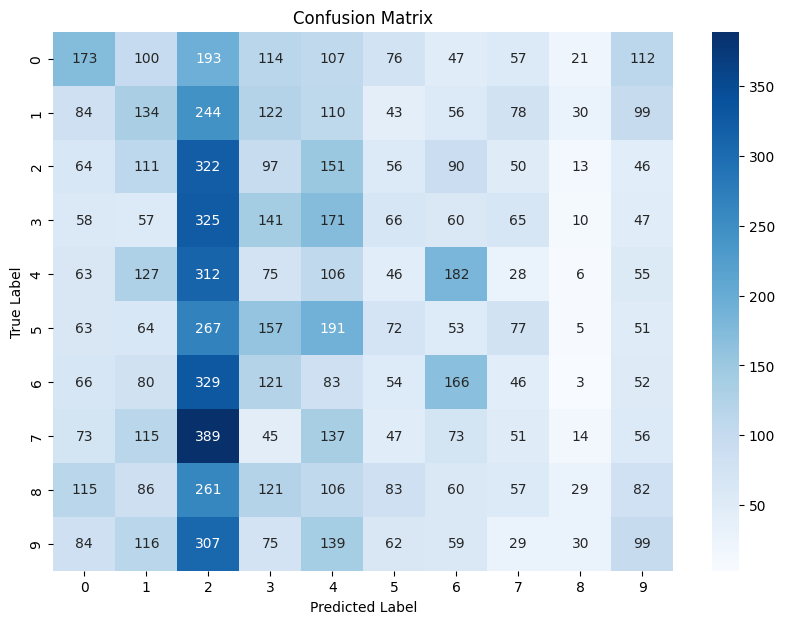


Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.17      0.19      1000
           1       0.14      0.13      0.13      1000
           2       0.11      0.32      0.16      1000
           3       0.13      0.14      0.14      1000
           4       0.08      0.11      0.09      1000
           5       0.12      0.07      0.09      1000
           6       0.20      0.17      0.18      1000
           7       0.09      0.05      0.07      1000
           8       0.18      0.03      0.05      1000
           9       0.14      0.10      0.12      1000

    accuracy                           0.13     10000
   macro avg       0.14      0.13      0.12     10000
weighted avg       0.14      0.13      0.12     10000



(2.385298728942871, 0.12929999828338623)

In [88]:
print("Evaluation of the Fine-Tuned Model:")
evaluate_model(model, test_dataset)